In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from ast import literal_eval
%matplotlib inline

In [2]:
# set default figsize
plt.rcParams['figure.figsize'] = [12, 4]

In [3]:
DATA_PATH = 'data/ustore/'

## Prepare test data

In [9]:
test = pd.read_csv(DATA_PATH+'raw/future.csv')
test = test[test.user_eval_set=='test']
test = test.groupby('user_id')['item_id'].apply(list)
test.head()

user_id
0                                              [15318]
1    [42254, 43293, 53245, 63421, 65270, 65271, 84728]
2                                [33085, 34405, 53820]
3                                              [63192]
4                                        [2851, 44271]
Name: item_id, dtype: object

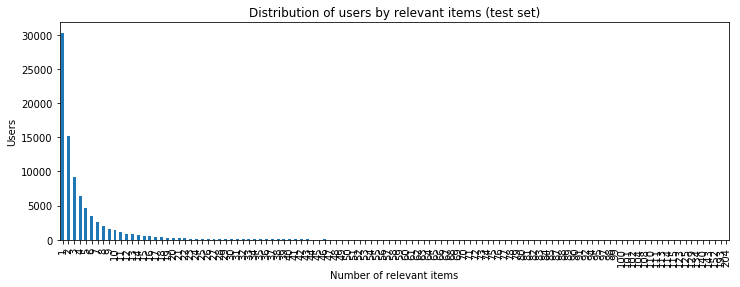

In [12]:
aux = test.apply(lambda x: len(x)).value_counts().sort_index()
aux.plot(kind='bar')
plt.xlim(-0.5, len(aux)-.5)
plt.title('Distribution of users by relevant items (test set)')
plt.xlabel('Number of relevant items')
plt.ylabel('Users')
plt.show()

## Load recommendations

In [54]:
alg_list = [
    'popular',
    'itemknn',
    'userknn',
    'als',
    'bpr'
]
alg_rec = {}
for alg in alg_list:
    alg_rec[alg] = pd.read_csv(DATA_PATH+'predictions/' + alg + '.csv')
    alg_rec[alg].set_index('user_id', inplace=True)

## Evaluate

In [55]:
%%time
alg_perf = []
for u in test.index.values:
    
    perf_p_at_10 = []
    perf_r_at_10 = []
    perf_rr_at_100 = []
    perf_ndcg_at_100 = []
    
    for alg in alg_list:
        rec_list_relevance = [1 if x in test[u] else 0 for x in literal_eval(alg_rec[alg].loc[u].top100)]
        
        # P@10
        result = sum(rec_list_relevance[:10])/10
        perf_p_at_10.append([result, alg])
        
        # R@10
        result = sum(rec_list_relevance[:10])/len(test[u])
        perf_r_at_10.append([result, alg])
        
        # RR@100
        result = 0
        if 1 in rec_list_relevance:
            result = 1/(1+rec_list_relevance.index(1))
        perf_rr_at_100.append([result, alg])
        
        # NDCG@100
        dcg = 0
        for i in range(len(rec_list_relevance)):
            dcg += rec_list_relevance[i]/np.log2(2+i)        
        idcg = 0
        for i in range(len(test[u])):
            idcg += 1/np.log2(2+i)
        perf_ndcg_at_100.append([dcg/idcg, alg])
        
    perf_p_at_10.sort(reverse=True)
    perf_r_at_10.sort(reverse=True)
    perf_rr_at_100.sort(reverse=True)
    perf_ndcg_at_100.sort(reverse=True)
    alg_perf.append({
        'user_id': u,
        'P@10': perf_p_at_10,
        'R@10': perf_r_at_10,
        'RR@100': perf_rr_at_100,
        'NDCG@100': perf_ndcg_at_100
    })
    
perf = pd.DataFrame(alg_perf)

CPU times: user 35min 48s, sys: 4.64 s, total: 35min 53s
Wall time: 35min 56s


In [56]:
perf.to_csv(DATA_PATH+'rs_performance.csv', index=False)

## Performance analysis

In [57]:
perf.head()

,NDCG@100,P@10,R@10,RR@100,user_id
0,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",0
1,"[[0.11838279295536291, bpr], [0.05780921899607...","[[0.1, bpr], [0.0, userknn], [0.0, popular], [...","[[0.14285714285714285, bpr], [0.0, userknn], [...","[[0.25, bpr], [0.038461538461538464, als], [0,...",1
2,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",2
3,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",3
4,"[[0.5802792108518124, userknn], [0.37007816335...","[[0.2, userknn], [0.1, bpr], [0.0, popular], [...","[[1.0, userknn], [0.5, bpr], [0.0, popular], [...","[[0.5, userknn], [0.14285714285714285, bpr], [...",4


### NDCG@100

In [58]:
# how many users have optimal algorithm
metric = 'NDCG@100'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

24002

[]

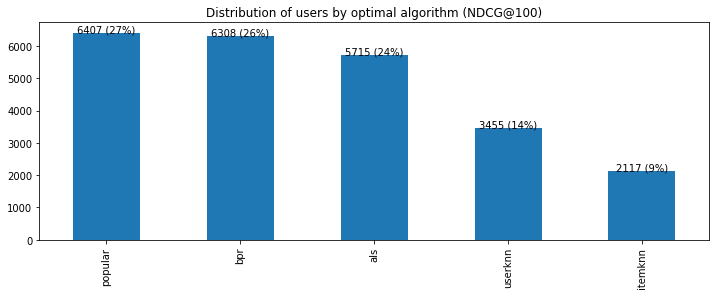

In [59]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 10.14), ha='center')
plt.plot()

In [60]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    23327
True       675
Name: NDCG@100, dtype: int64

In [61]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'mean '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                            .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'nonzero count '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                            .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum()
        })
    
pd.DataFrame(mean_perf).sort_values(by='mean '+metric, ascending=False)

,algorithm,mean NDCG@100,nonzero count NDCG@100
4,bpr,0.119100,12821
3,als,0.096038,12047
2,userknn,0.079299,11866
1,itemknn,0.064949,7726
0,popular,0.043314,9010


In [62]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero NDCG@100,mean NDCG@100 (all users),mean NDCG@100 (users with ANY optimal alg),mean NDCG@100 (users with THIS optimal alg)
4,bpr,12821,0.033567,0.119100,0.252545
3,als,12047,0.027068,0.096038,0.202794
2,userknn,11866,0.022350,0.079299,0.200930
1,itemknn,7726,0.018305,0.064949,0.315913
0,popular,9010,0.012208,0.043314,0.128423


In [63]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean NDCG@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.2057254512092359
Baseline - best single algorithm:  0.11909962770827906
Possible relative improvement:  72.73 %


In [64]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean NDCG@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.05798220171115981
Baseline - best single algorithm:  0.03356735200683545
Possible relative improvement:  72.73 %


### MRR@100

In [65]:
# how many users have optimal algorithm
metric = 'RR@100'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

24002

[]

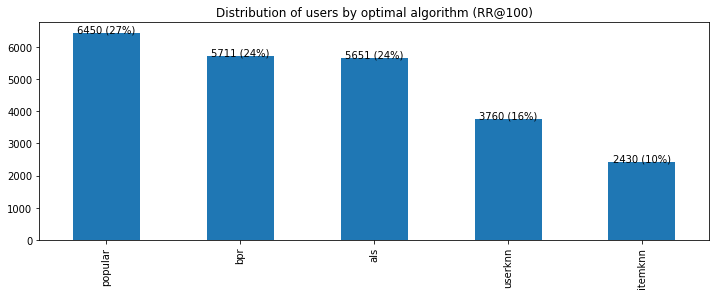

In [66]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 10.14), ha='center')
plt.plot()

In [67]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    22450
True      1552
Name: RR@100, dtype: int64

In [68]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero RR@100,mean RR@100 (all users),mean RR@100 (users with ANY optimal alg),mean RR@100 (users with THIS optimal alg)
4,bpr,12821,0.032858,0.116581,0.280364
3,als,12047,0.029124,0.103334,0.225516
2,userknn,11866,0.018421,0.065358,0.251922
1,itemknn,7726,0.018234,0.064695,0.422418
0,popular,9010,0.010306,0.036565,0.114699


In [69]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean RR@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.23285805412140517
Baseline - best single algorithm:  0.11658138027317756
Possible relative improvement:  99.74 %


In [70]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean RR@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.06562932580667168
Baseline - best single algorithm:  0.032857602533046905
Possible relative improvement:  99.74 %


### P@10

In [71]:
# how many users have optimal algorithm
metric = 'P@10'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

10509

[]

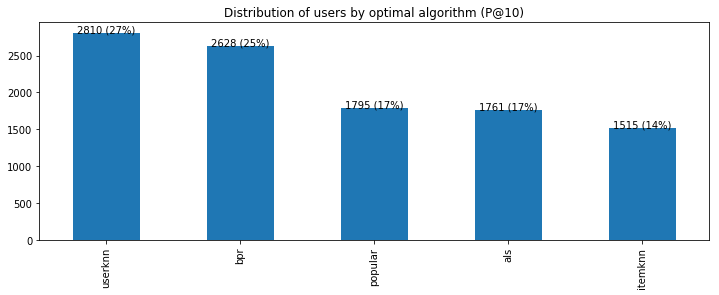

In [72]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 3.14), ha='center')
plt.plot()

In [73]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    6461
True     4048
Name: P@10, dtype: int64

In [74]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero P@10,mean P@10 (all users),mean P@10 (users with ANY optimal alg),mean P@10 (users with THIS optimal alg)
4,bpr,5616,0.008540,0.069207,0.143493
3,als,5039,0.007579,0.061414,0.140886
2,userknn,3580,0.004847,0.039281,0.114093
1,itemknn,2943,0.004185,0.033914,0.129241
0,popular,2128,0.002716,0.022010,0.109805


In [75]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean P@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.12738605005233217
Baseline - best single algorithm:  0.06920734608431478
Possible relative improvement:  84.06 %


In [76]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean P@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.015719636923004175
Baseline - best single algorithm:  0.008540294266155447
Possible relative improvement:  84.06 %


### R@10

In [77]:
# how many users have optimal algorithm
metric = 'R@10'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

10509

[]

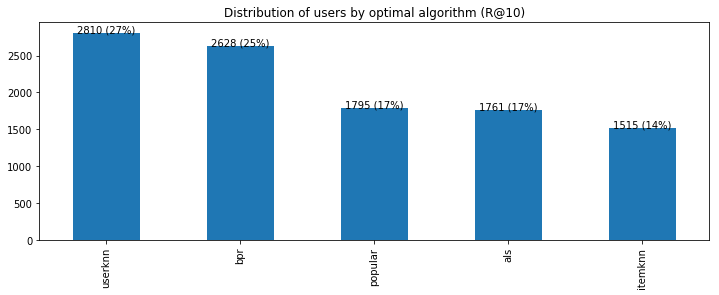

In [78]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 3.14), ha='center')
plt.plot()

In [79]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    6461
True     4048
Name: R@10, dtype: int64

In [80]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero R@10,mean R@10 (all users),mean R@10 (users with ANY optimal alg),mean R@10 (users with THIS optimal alg)
4,bpr,5616,0.028213,0.228627,0.411488
3,als,5039,0.022378,0.181341,0.340328
2,userknn,3580,0.016172,0.131054,0.432940
1,itemknn,2943,0.015584,0.126287,0.476425
0,popular,2128,0.008065,0.065356,0.328206


In [81]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean R@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.40043618157389355
Baseline - best single algorithm:  0.22862666207505908
Possible relative improvement:  75.15 %


In [82]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean R@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.049414448305680383
Baseline - best single algorithm:  0.02821288608338084
Possible relative improvement:  75.15 %
